In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [3]:
schedules = pd.read_csv('data/datasets/schedules_to_may_2024.csv', sep='|')

In [4]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)
schedules['portId'] = schedules['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)
schedules['vesselId'] = schedules['vesselId'].map(vessel_id_mapping)


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)
schedules['shippingLineId'] = schedules['shippingLineId'].map(shipping_line_id_mapping)

In [5]:
import pytz
schedules['sailingDate'] = pd.to_datetime(schedules['sailingDate'], errors='coerce')
schedules['arrivalDate'] = pd.to_datetime(schedules['arrivalDate'], errors='coerce')

# Convert sailingDate and arrivalDate to a different timezone, such as CET (Central European Time)
# Convert datetime columns to timezone-naive format by removing timezone info
schedules['sailingDate'] = schedules['sailingDate'].dt.tz_convert(None)
schedules['arrivalDate'] = schedules['arrivalDate'].dt.tz_convert(None)


schedules.head()


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,72.0,5,Wallenius Wilhelmsen Ocean,2023-10-02,2023-10-03,Port of Brunswick,122.0,31.140556,-81.496667
1,72.0,5,Wallenius Wilhelmsen Ocean,2023-10-27,2023-10-27,Port of Southampton,57.0,50.902500,-1.428889
2,72.0,5,Wallenius Wilhelmsen Ocean,2023-10-19,2023-10-20,Port of Bremerhaven,39.0,53.563611,8.554722
3,72.0,5,Wallenius Wilhelmsen Ocean,2023-10-09,2023-10-10,Port of New York,160.0,40.688333,-74.028611
4,72.0,5,Wallenius Wilhelmsen Ocean,2023-09-25,2023-09-26,Manzanillo International Terminal,365.0,9.372370,-79.879790


In [6]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,65.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,255.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,68.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [7]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [8]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'breadth', 'GT']], on='vesselId', how='left')
# train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_breadth_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_breadth_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,breadth,GT
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,32.00,57718
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,32.26,59583
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,32.00,59217
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,32.00,55598
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,32.20,58939


In [9]:
# Calculate the mean breadth for shipping line 5
mean_breadth_shipping_line_5 = train[train['shippingLineId'] == 5]['breadth'].mean()

# Impute missing breadth with the calculated mean
train.loc[train['shippingLineId'] == 5, 'breadth'] = train.loc[train['shippingLineId'] == 5, 'breadth'].fillna(mean_breadth_shipping_line_5)

# Verify if the missing values were filled
missing_count_after_imputation = train['breadth'].isnull().sum()
print(f"Missing Breadth values after imputation: {missing_count_after_imputation}")


Missing Breadth values after imputation: 0


In [10]:
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   time            1522065 non-null  datetime64[ns]
 1   cog             1522065 non-null  float64       
 2   sog             1522065 non-null  float64       
 3   rot             1522065 non-null  int64         
 4   heading         1522065 non-null  int64         
 5   navstat         1522065 non-null  int64         
 6   etaRaw          1522065 non-null  object        
 7   latitude        1522065 non-null  float64       
 8   longitude       1522065 non-null  float64       
 9   vesselId        1522065 non-null  int64         
 10  portId          1522065 non-null  int64         
 11  latitude_port   1520450 non-null  float64       
 12  longitude_port  1520450 non-null  float64       
 13  length          1522065 non-null  float64       
 14  shippingLineId  15

In [11]:
train = train.dropna()

In [ ]:
train['time'] = pd.to_datetime(train['time'])

# Define the minimum required date for prediction (5 days before the latest date in the dataset)
prediction_start_date = train['time'].max()  # Use the latest date in the dataset as the prediction start date
min_required_date = prediction_start_date

# Filter vessels based on whether they have data up to the required date
vessels_with_complete_data = train.groupby('vesselId').filter(
    lambda x: x['time'].max() >= min_required_date
)['vesselId'].unique()

# Identify vessels with incomplete data
vessels_with_incomplete_data = train['vesselId'].unique()
vessels_with_incomplete_data = [v for v in vessels_with_incomplete_data if v not in vessels_with_complete_data]

print("Vessels with incomplete data, missing days up to the last day or the day before prediction:", vessels_with_incomplete_data)

Vessels with incomplete data, missing days up to the last day or the day before prediction: [0, 1, 3, 10, 15, 30, 40, 45, 49, 52, 58, 74, 80, 81, 82, 84, 93, 102, 106, 111, 113, 121, 122, 124, 127, 131, 143, 152, 153, 157, 161, 163, 186, 198, 202, 221, 225, 230, 231, 243, 244, 246, 247, 251, 263, 267, 274, 285, 286, 288, 295, 304, 311, 314, 320, 322, 323, 330, 332, 337, 339, 345, 346, 349, 353, 354, 359, 360, 361, 362, 368, 372, 374, 375, 378, 385, 386, 390, 391, 394, 395, 396, 400, 401, 415, 419, 420, 421, 425, 438, 440, 441, 445, 446, 448, 451, 453, 456, 458, 462, 463, 464, 469, 472, 474, 486, 489, 494, 496, 498, 499, 500, 503, 504, 514, 520, 523, 528, 529, 531, 534, 539, 548, 551, 556, 562, 569, 570, 571, 573, 574, 576, 579, 582, 584, 587, 588, 591, 597, 598, 601, 605, 609, 611, 612, 615, 621, 622, 626, 629, 630, 632, 635, 642, 643, 647, 649, 655, 661, 663, 664, 666, 667, 668, 675, 677, 679, 682, 685]



Minimum required date:
2024-05-07 23:59:08


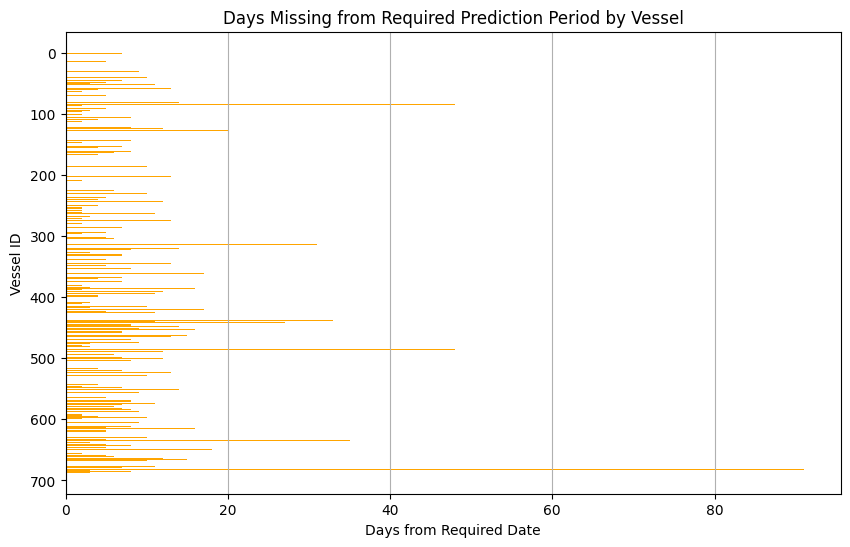

In [13]:
df_days_before_prediction = train.copy()
# Ensure 'time' column is in datetime format
df_days_before_prediction['time'] = pd.to_datetime(df_days_before_prediction['time'])


# Specify the year to append
current_year = 2024  # Change to the desired year

# Modify etaRaw to include the year
df_days_before_prediction['etaRaw'] = df_days_before_prediction['etaRaw'].apply(lambda x: f"{current_year}-{x}")


# Convert 'etaRaw' column to datetime
df_days_before_prediction['etaRaw'] = pd.to_datetime(df_days_before_prediction['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')

# Define the start of the prediction period and calculate minimum required date
prediction_start_date = df_days_before_prediction['time'].max()
days_before_start = 0  # Set to the number of days you want before the start date
min_required_date = prediction_start_date 

# Get the last recorded date for each vessel along with `etaRaw`
vessel_last_dates = df_days_before_prediction.groupby('vesselId').agg({'time': 'max', 'etaRaw': 'last'}).reset_index()
vessel_last_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Check the minimum required date
print("\nMinimum required date:")
print(min_required_date)

# Add a new column to indicate if etaRaw is before the minimum required date
vessel_last_dates['etaRaw_before_required'] = vessel_last_dates['etaRaw'] < min_required_date

# Calculate days missing from the required date
vessel_last_dates['days_from_required'] = (min_required_date - vessel_last_dates['last_train_time']).dt.days

# Add a new column to indicate if the data is before the required date
vessel_last_dates['before_required_date'] = vessel_last_dates['days_from_required'] > 1

# Separate vessels with incomplete data
vessels_with_incomplete_data = vessel_last_dates[vessel_last_dates['before_required_date']]

# Plot vessels with incomplete data
plt.figure(figsize=(10, 6))
plt.barh(vessels_with_incomplete_data['vesselId'], vessels_with_incomplete_data['days_from_required'], color='orange')
plt.xlabel('Days from Required Date')
plt.ylabel('Vessel ID')
plt.title('Days Missing from Required Prediction Period by Vessel')
plt.gca().invert_yaxis()  # Invert y-axis to have the vessel with the most missing days on top
plt.grid(axis='x')  # Add gridlines for better readability
plt.show()



In [14]:
# Define the minimum required date for predictions in the test set
min_required_date = test['time'].min()   # 5 days before the earliest test date
print(f"Minimum required date for predictions: {min_required_date}")

# Filter the schedules DataFrame based on the required date
schedules_filtered = schedules[~((schedules['sailingDate'] < min_required_date) & 
                                  (schedules['arrivalDate'] < min_required_date))]

# Get the last recorded date for each vessel in the training set
last_train_dates = train.groupby('vesselId')['time'].max().reset_index()
last_train_dates.rename(columns={'time': 'last_train_time'}, inplace=True)

# Print the filtered schedules for verification
# print("Filtered schedules:")
# print(schedules_filtered.head())

# Filter vessels that are in the test set
vessels_in_test = test['vesselId'].unique()
missing_days_df = last_train_dates[last_train_dates['vesselId'].isin(vessels_in_test)].copy()

# Calculate the days missing for each vessel from the required date
missing_days_df['days_missing'] = (min_required_date - missing_days_df['last_train_time']).dt.days

# Filter vessels missing a significant number of days (e.g., more than 2 days)
significant_gap_vessels = missing_days_df[missing_days_df['days_missing'] > 1]

# Print the vessels with significant gaps
print("Vessels in the test set missing significant data before prediction date:")
print(significant_gap_vessels[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days: {len(significant_gap_vessels)}")

# Optional: If you want to check which vessels are in filtered schedules
vessels_in_filtered_schedules = schedules_filtered['vesselId'].unique()
print(f"Number of unique vessels in filtered schedules: {len(vessels_in_filtered_schedules)}")

# Step to find which significant gap vessels are in filtered schedules
vessels_in_gap_and_schedule = set(significant_gap_vessels['vesselId']).intersection(vessels_in_filtered_schedules)

# Create a DataFrame for common vessels with significant gaps in schedules
vessels_in_gap_and_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_and_schedule)]


# Print results
print("Vessels with significant gaps that are also in the filtered schedules:")
print(vessels_in_gap_and_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are in schedules: {len(vessels_in_gap_and_schedule_df)}")

Minimum required date for predictions: 2024-05-08 00:03:16
Vessels in the test set missing significant data before prediction date:
     vesselId     last_train_time  days_missing
3           3 2024-04-26 13:29:25            11
30         30 2024-04-28 19:17:28             9
80         80 2024-04-28 04:45:55             9
81         81 2024-04-23 23:00:00            14
244       244 2024-04-27 21:40:48            10
283       283 2024-05-04 17:29:58             3
327       327 2024-05-04 15:17:17             3
345       345 2024-04-24 07:16:53            13
353       353 2024-04-29 00:05:23             8
359       359 2024-04-26 13:50:08            11
368       368 2024-04-30 07:08:07             7
378       378 2024-04-11 05:44:29            26
385       385 2024-04-30 22:02:25             7
417       417 2024-05-04 13:34:51             3
508       508 2024-05-03 22:32:02             4
528       528 2024-04-27 13:07:07            10
548       548 2024-04-30 18:39:21             7
564 

In [15]:

# Step to find which significant gap vessels are NOT in filtered schedules
vessels_in_gap_not_in_schedule = set(significant_gap_vessels['vesselId']).difference(vessels_in_filtered_schedules)

# Create a DataFrame for vessels with significant gaps that are not in the schedules
vessels_in_gap_not_in_schedule_df = significant_gap_vessels[significant_gap_vessels['vesselId'].isin(vessels_in_gap_not_in_schedule)]

# Print results
print("Vessels with significant gaps that are NOT in the filtered schedules:")
print(vessels_in_gap_not_in_schedule_df[['vesselId', 'last_train_time', 'days_missing']])
print(f"Number of vessels with significant missing days that are NOT in schedules: {len(vessels_in_gap_not_in_schedule_df)}")

Vessels with significant gaps that are NOT in the filtered schedules:
     vesselId     last_train_time  days_missing
30         30 2024-04-28 19:17:28             9
81         81 2024-04-23 23:00:00            14
327       327 2024-05-04 15:17:17             3
345       345 2024-04-24 07:16:53            13
353       353 2024-04-29 00:05:23             8
359       359 2024-04-26 13:50:08            11
378       378 2024-04-11 05:44:29            26
385       385 2024-04-30 22:02:25             7
508       508 2024-05-03 22:32:02             4
528       528 2024-04-27 13:07:07            10
587       587 2024-04-28 23:44:44             9
615       615 2024-04-21 08:15:03            16
632       632 2024-04-29 18:08:30             8
647       647 2024-04-26 22:05:53            11
656       656 2024-05-05 03:27:01             2
675       675 2024-04-12 06:09:24            25
Number of vessels with significant missing days that are NOT in schedules: 16


In [16]:
schedules_filtered.head()

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
8,616.0,0,Hoegh Autoliners,2024-06-02 10:00:00,2024-06-04 10:00:00,Port of Durban,171.0,-29.881111,31.027222
9,616.0,0,Hoegh Autoliners,2024-05-18 22:15:00,2024-05-18 22:30:00,Port of Sohar,244.0,24.378333,56.740556
10,616.0,0,Hoegh Autoliners,2024-05-16 19:00:00,2024-05-16 22:00:00,Port of Shuaiba,510.0,29.044722,48.159722
11,616.0,0,Hoegh Autoliners,2024-07-07 10:00:00,2024-07-08 08:30:00,Port of Jacksonville,42.0,30.380833,-81.564444
13,616.0,0,Hoegh Autoliners,2024-06-23 10:00:00,2024-06-24 10:00:00,Port of Kingston,307.0,17.981667,-76.829444


In [17]:
print(train.head())
print(train.info())
print("Number of missing values in each column:\n", train.isnull().sum())

                 time    cog   sog  rot  heading  navstat       etaRaw  \
0 2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1 2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2 2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3 2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4 2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   

   latitude  longitude  vesselId  portId  latitude_port  longitude_port  \
0 -34.74370  -57.85130         0       0       -33.5875      -71.618889   
1   8.89440  -79.47939         1       1         8.9670      -79.533000   
2  39.19065  -76.47567         2       2        39.2325      -76.558889   
3 -34.41189  151.02067         3       3       -34.4625      150.899444   
4  35.88379   -5.91636         4       4        35.7830       -5.817000   

   length  shippingLineId  breadth     GT  
0  199.00               9    32.00  57718  
1  199.97       

In [18]:

def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    window_size_days = 5
    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        for start_idx in range(len(unique_dates) - window_size_days + 1):
            start_date = unique_dates[start_idx]
            end_date = unique_dates[start_idx + window_size_days - 1]
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # Skip empty windows
            if len(window) == 0:
                continue

            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'cog_sin': row['cog_sin'],
                    'cog_cos': row['cog_cos'],
                    'cog' : row['cog'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    'length' : row['length'],
                    'breadth': row['breadth'],
                    # 'DWT': row['DWT'],
                    'GT': row['GT'],
                    # 'vessel_deep_sea': row['vessel_deep_sea'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_sin_first': reference_row['cog_sin'],
                    'cog_cos_first': reference_row['cog_cos'],
                    'sog_first': reference_row['sog'],
                    'rot_first': reference_row['rot'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

    return pd.DataFrame(windows)

In [19]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

In [20]:
from scipy.spatial import ConvexHull

def calculate_convex_hull_area(lats, lons):
    """Calculate the area of the convex hull formed by the given latitudes and longitudes."""
    # Create a 2D array of coordinates
    points = np.array(list(zip(lons, lats)))  # Note: Longitude first for ConvexHull
    if len(points) < 3:  # Convex hull requires at least 3 points
        return 0.0  # No area if fewer than 3 points
    
    # Calculate the convex hull
    hull = ConvexHull(points)
    
    # Calculate area based on the convex hull
    return hull.volume  # Volume is the area for 2D

In [21]:
def future_position(lat, lon, cog, sog, time_diff):
    """
    Calculate the future position given the current latitude, longitude, COG, SOG, and time difference in seconds.
    """
    # Convert COG from degrees to radians
    cog_rad = np.radians(cog)

    # Calculate distance traveled in meters
    distance = sog * time_diff  # distance = speed * time

    # Calculate future latitude and longitude
    future_lat = lat + (distance * np.cos(cog_rad)) / 111320  # 111320 meters per degree latitude
    future_lon = lon + (distance * np.sin(cog_rad)) / (111320 * np.cos(np.radians(lat)))  # adjust for longitude

    return future_lat, future_lon

### Feature engineering 

In [22]:
def feature_engineering(train):
    train = train.copy()
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # # Handle NaNs
    # train[['latitude', 'longitude', 'cog', 'time']] = (
    #     train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    # ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time'] 
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    features['cog_rad'] = np.radians(features['cog'])
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])
    features['length'] = train['length']
    features['breadth'] = train['breadth']
    features['GT'] = train['GT']
    
    features = create_five_day_windows(features)

    features['latitude_port'] = train['latitude_port']
    features['longitude_port'] = train['longitude_port']

    features['distance_to_port'] = haversine(features['latitude'], features['longitude'], 
                                              features['latitude_port'], features['longitude_port'])
    
    # features['time_diff'] = features.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

    # # Calculate future positions
    # future_positions = features.apply(lambda row: future_position(
    #     row['latitude'], row['longitude'], row['cog'], row['sog'], row['time_diff']), axis=1)

    # features['future_latitude'], features['future_longitude'] = zip(*future_positions)
    
    # features['area_covered'] = features.apply(lambda row: calculate_convex_hull_area(
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['latitude'].tolist(),
    #     features[(features['vesselId'] == row['vesselId']) & (features['time'] <= row['time'])]['longitude'].tolist()), axis=1)

    # # Calculate cumulative area covered for each vessel
    # features['cumulative_area_covered'] = features.groupby('vesselId')['area_covered'].cumsum()
 
    # Additional time-based features
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute
    # features['day_of_week'] = features['time'].dt.dayofweek

    return features

train_features = feature_engineering(train)

In [23]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7186789 entries, 0 to 7186788
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   vesselId          int64         
 1   time              datetime64[ns]
 2   latitude          float64       
 3   longitude         float64       
 4   cog_sin           float64       
 5   cog_cos           float64       
 6   cog               float64       
 7   sog               float64       
 8   rot               int64         
 9   under_way         int64         
 10  length            float64       
 11  breadth           float64       
 12  GT                int64         
 13  latitude_first    float64       
 14  longitude_first   float64       
 15  cog_sin_first     float64       
 16  cog_cos_first     float64       
 17  sog_first         float64       
 18  rot_first         int64         
 19  under_way_first   int32         
 20  time_since_start  float64       
 21  latitude

In [24]:
nan_values = train_features.isnull().sum()
print(nan_values)


# Drop the columns 'time' and 'rot'
train_features = train_features.drop(columns=['time', 'rot_first'])

vesselId                  0
time                      0
latitude                  0
longitude                 0
cog_sin                   0
cog_cos                   0
cog                       0
sog                       0
rot                       0
under_way                 0
length                    0
breadth                   0
GT                        0
latitude_first            0
longitude_first           0
cog_sin_first             0
cog_cos_first             0
sog_first                 0
rot_first                 0
under_way_first           0
time_since_start          0
latitude_port       5666339
longitude_port      5666339
distance_to_port    5666339
month                     0
day                       0
hour                      0
minute                    0
dtype: int64


In [25]:
train_features.head()

,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,-34.74370,-57.85130,-0.970296,0.241922,284.0,0.7,0,1,199.0,...,0.7,1,0.0,-33.5875,-71.618889,1272.179414,1,1,0,0
1,0,-35.16787,-56.77210,0.998806,-0.048850,92.8,14.2,0,1,199.0,...,0.7,1,22123.0,-33.5875,-71.618889,1372.504428,1,1,6,9
2,0,-35.16863,-56.63185,0.999962,-0.008727,90.5,14.3,0,1,199.0,...,0.7,1,23874.0,-33.5875,-71.618889,1385.239318,1,1,6,38
3,0,-35.16805,-56.53190,0.999507,0.031411,88.2,14.3,0,1,199.0,...,0.7,1,25110.0,-33.5875,-71.618889,1394.309141,1,1,6,58
4,0,-35.16715,-56.45306,0.999560,0.029666,88.3,12.3,0,1,199.0,...,0.7,1,26131.0,-33.5875,-71.618889,1401.461476,1,1,7,15


In [26]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
# last_features.drop(columns=['DWT']) 
last_features.head()


,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,0,34.57936,128.99926,-0.662620,-0.748956,221.5,15.5,0,1,199.00,...,0.4,0,1340708.0,-34.190000,18.436944,13780.000982,5,1,12,41
1,1,1.24460,103.39997,-0.818150,0.575005,305.1,15.7,11,1,199.97,...,0.1,0,2195733.0,12.624444,100.919722,1294.559039,4,30,10,12
2,2,18.13873,-69.74863,0.069756,-0.997564,176.0,0.4,0,1,199.00,...,0.0,0,603974.0,53.344444,-6.209444,6652.930691,5,7,23,59
3,3,41.64055,143.29942,0.999123,0.041876,87.6,14.4,0,1,199.00,...,9.7,1,455585.0,17.633000,-101.550000,10654.769565,4,26,13,29
4,4,26.58710,121.27831,0.630676,0.776046,39.1,12.7,0,1,199.95,...,0.0,0,562766.0,53.524722,9.963333,8940.848077,5,7,12,28


### Train the model

In [27]:
# # Define features and target
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=['latitude', 'longitude', 'vesselId']) 
X.head()

,cog_sin,cog_cos,cog,sog,rot,under_way,length,breadth,GT,latitude_first,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
0,-0.970296,0.241922,284.0,0.7,0,1,199.0,32.0,57718,-34.7437,...,0.7,1,0.0,-33.5875,-71.618889,1272.179414,1,1,0,0
1,0.998806,-0.048850,92.8,14.2,0,1,199.0,32.0,57718,-34.7437,...,0.7,1,22123.0,-33.5875,-71.618889,1372.504428,1,1,6,9
2,0.999962,-0.008727,90.5,14.3,0,1,199.0,32.0,57718,-34.7437,...,0.7,1,23874.0,-33.5875,-71.618889,1385.239318,1,1,6,38
3,0.999507,0.031411,88.2,14.3,0,1,199.0,32.0,57718,-34.7437,...,0.7,1,25110.0,-33.5875,-71.618889,1394.309141,1,1,6,58
4,0.999560,0.029666,88.3,12.3,0,1,199.0,32.0,57718,-34.7437,...,0.7,1,26131.0,-33.5875,-71.618889,1401.461476,1,1,7,15


In [28]:
best_model = RandomForestRegressor(max_depth=25, random_state=42, n_jobs=-1)

# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 300],            # Number of trees in the forest
#     'max_depth': [5, 10, 25, None],             # Maximum depth of the tree
#     'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
#     'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
# }

# # Perform Randomized Search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                                    n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
# random_search.fit(X, y)

# best_model = random_search.best_estimator_

# # Output the best parameters and score
# print(f"Best parameters: {random_search.best_params_}")
# print(f"Best score (negative mean squared error): {-random_search.best_score_}")

# # best_model = xgb.XGBRegressor()

# Fit the model
best_model.fit(X, y)


RandomForestRegressor(max_depth=25, n_jobs=-1, random_state=42)

In [29]:

# Step 1: Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Step 2: Print feature importances
print("Feature Importances:")
print(features_df)

Feature Importances:
             Feature  Importance
10   longitude_first    0.739001
15  time_since_start    0.115180
9     latitude_first    0.079880
8                 GT    0.013979
11     cog_sin_first    0.010984
6             length    0.006378
13         sog_first    0.005909
7            breadth    0.005353
12     cog_cos_first    0.004565
20               day    0.004045
3                sog    0.003519
0            cog_sin    0.003342
19             month    0.002147
18  distance_to_port    0.001563
2                cog    0.001162
1            cog_cos    0.000796
17    longitude_port    0.000600
16     latitude_port    0.000566
5          under_way    0.000512
14   under_way_first    0.000224
21              hour    0.000164
4                rot    0.000098
22            minute    0.000034


In [30]:
X.head()
X.columns

Index(['cog_sin', 'cog_cos', 'cog', 'sog', 'rot', 'under_way', 'length',
       'breadth', 'GT', 'latitude_first', 'longitude_first', 'cog_sin_first',
       'cog_cos_first', 'sog_first', 'under_way_first', 'time_since_start',
       'latitude_port', 'longitude_port', 'distance_to_port', 'month', 'day',
       'hour', 'minute'],
      dtype='object')

create last_features for the ones that are probably standing still as they are not in schedules 

In [31]:
last_features_gap = last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].copy()
last_features_gap.head()

last_features_gap['under_way'] = 0  # Stationary mode
last_features_gap['sog'] = 0        # Speed over ground to 0
last_features_gap['rot'] = 0        # Rate of turn to 0
last_features_gap['cog'] = 0        # Optional: course over ground to 0
last_features_gap['cog_sin'] = 0    # Sine of course to 0
last_features_gap['cog_cos'] = 1    # Cosine of course to 1
last_features_gap['distance_to_port'] = 0
last_features_gap['time_since_start'] = 0


# Align with the maximum time and date fields in last_features
last_features_gap['day'] = 6 #sunday before 8th of May 
last_features_gap['month'] = last_features['month'].max()
# last_features_gap['minute'] = last_features['minute'].max()
last_features_gap = last_features_gap.drop(columns=['year'], errors='ignore')

# # Explicitly cast each column in last_features_gap to match last_features data types
# for column in last_features_gap.columns:
#     if column in last_features.columns:
#         last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


last_features_gap.columns
last_features_gap.head()


,vesselId,latitude,longitude,cog_sin,cog_cos,cog,sog,rot,under_way,length,...,sog_first,under_way_first,time_since_start,latitude_port,longitude_port,distance_to_port,month,day,hour,minute
30,30,35.33234,142.69115,0,1,0,0,0,0,199.97,...,12.7,1,0,51.336389,3.207222,0,5,6,19,17
81,81,38.77321,118.79824,0,1,0,0,0,0,199.99,...,13.4,1,0,8.955556,-79.570000,0,5,6,23,0
327,327,35.83590,14.62925,0,1,0,0,0,0,176.72,...,13.6,1,0,NaN,NaN,0,5,6,15,17
345,345,34.36324,-120.54771,0,1,0,0,0,0,199.94,...,16.7,1,0,NaN,NaN,0,5,6,7,16
353,353,-33.79642,17.46789,0,1,0,0,0,0,199.00,...,15.4,1,0,NaN,NaN,0,5,6,0,5


In [32]:
# Ensure columns in last_features_gap match data types of last_features
# Ensure compatibility by casting last_features_gap columns to the same dtype as last_features
for column in last_features.columns:
    if column in last_features_gap.columns:
        print(f"Casting {column} to {last_features[column].dtype}")
        last_features_gap[column] = last_features_gap[column].astype(last_features[column].dtype)


# Now proceed to update last_features
last_features.update(last_features_gap)

# Now proceed with the update as before
last_features.set_index('vesselId', inplace=True)
last_features_gap.set_index('vesselId', inplace=True)
last_features.update(last_features_gap)

# Reset index if needed for subsequent operations
last_features.reset_index(inplace=True)
last_features_gap.reset_index(inplace=True)

# Check a sample to verify the updates have been applied
print(last_features[last_features['vesselId'].isin(vessels_in_gap_not_in_schedule_df['vesselId'])].head())


Casting vesselId to int64
Casting latitude to float64
Casting longitude to float64
Casting cog_sin to float64
Casting cog_cos to float64
Casting cog to float64
Casting sog to float64
Casting rot to int64
Casting under_way to int64
Casting length to float64
Casting breadth to float64
Casting GT to int64
Casting latitude_first to float64
Casting longitude_first to float64
Casting cog_sin_first to float64
Casting cog_cos_first to float64
Casting sog_first to float64
Casting under_way_first to int32
Casting time_since_start to float64
Casting latitude_port to float64
Casting longitude_port to float64
Casting distance_to_port to float64
Casting month to int32
Casting day to int32
Casting hour to int32
Casting minute to int32
     vesselId  latitude  longitude  cog_sin  cog_cos  cog  sog  rot  \
30         30  35.33234  142.69115      0.0      1.0  0.0  0.0    0   
81         81  38.77321  118.79824      0.0      1.0  0.0  0.0    0   
327       327  35.83590   14.62925      0.0      1.0  0.0

C:\Users\ingvi\AppData\Local\Temp\ipykernel_8832\2154908180.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0
 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0
 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0
 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1
 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1
 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 

In [33]:
# Display rows with any NaN values in last_features
nan_rows = last_features[last_features.isna().any(axis=1)]
print(nan_rows)

# Alternatively, get a summary of NaNs in each column
nan_summary = last_features.isna().sum()
print("Summary of NaN values per column:")
print(nan_summary)

     vesselId  latitude  longitude   cog_sin   cog_cos    cog   sog  rot  \
95         95  50.81877    1.02754 -0.790155 -0.612907  232.2  18.0    0   
96         96  23.33350  117.96872 -0.730162 -0.683274  226.9  18.9    0   
97         97  13.06925  100.89367  0.788011 -0.615661  128.0   0.0    0   
98         98   1.27055  104.23015  0.982935  0.183951   79.4  15.1    0   
99         99  36.35295   -7.66749 -0.952661  0.304033  287.7  15.4    7   
..        ...       ...        ...       ...       ...    ...   ...  ...   
682       683  26.93694 -123.62850 -0.958820  0.284015  286.5  13.7    0   
683       684  36.64848  125.89047 -0.330514 -0.943801  199.3  18.5    0   
684       685 -33.86094   17.43360 -0.637424  0.770513  320.4  16.5    6   
685       686  30.33982  -88.57598 -0.764921 -0.644124  229.9   0.0    0   
686       687  37.22231  144.98452  0.864275  0.503020   59.8  14.9    0   

     under_way  length  ...  sog_first  under_way_first  time_since_start  \
95        

In [34]:
### Prepare test data for predictions
def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the reference row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_sin_first'] = prepared_test['cog_sin']
    prepared_test['cog_cos_first'] = prepared_test['cog_cos']  # Fixed typo here
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    # prepared_test['length'] = prepared_test['length']  # Ensure this column exists in 'prepared_test'
    # prepared_test['breadth'] = prepared_test['breadth']  # Ensure this column exists in 'prepared_test'
    # # prepared_test['DWT'] = prepared_test['DWT']  # Ensure this column exists in 'prepared_test'
    # prepared_test['GT'] = prepared_test['GT']  # Ensure this column exists in 'prepared_test'
    # prepared_test['vessel_deep_sea'] = prepared_test['vessel_deep_sea']  # Ensure this column exists in 'prepared_test'
    # prepared_test['rot'] = prepared_test['rot']  # Ensure this column exists in 'prepared_test'
    # # prepared_test['day_of_week'] = prepared_test['time'].dt.dayofweek  # Added missing day_of_week calculation

    # Drop the columns that are no longer needed
    prepared_test.drop(['time', 'time_last', 'year'], axis=1, inplace=True)

    # Reorder the columns
    prepared_test = prepared_test[['cog_sin', 'cog_cos', 'cog', 'sog', 'rot', 'under_way', 'length', 'breadth',
       'GT', 'latitude_first', 'longitude_first', 'cog_sin_first',
       'cog_cos_first', 'sog_first', 'under_way_first', 'time_since_start',
       'latitude_port', 'longitude_port', 'distance_to_port', 'month', 'day',
       'hour', 'minute'
                                ]]
    

    return prepared_test

# Prepare the test DataFrame
test_df = prepare_test_for_predictions(test, last_features)
print(test_df.head())
print(test_df.shape)


   vesselId                time  latitude  longitude   cog_sin   cog_cos  \
0       412 2024-05-08 00:03:16  31.14647  -81.49789  0.006981 -0.999976   
1       373 2024-05-08 00:06:17  14.81694  120.29625  0.417867  0.908508   
2       181 2024-05-08 00:10:02  38.27895   10.78280  0.139173  0.990268   
3         8 2024-05-08 00:10:34 -43.53785  172.83522 -0.625243  0.780430   
4        65 2024-05-08 00:12:27  48.53320   -6.12003 -0.933580  0.358368   

     cog   sog  rot  under_way  ...  time_since_start  latitude_port  \
0  179.6   0.0    0          0  ...          516824.0            NaN   
1   24.7   0.0    0          0  ...          776687.0            NaN   
2    8.0  18.7    0          1  ...          426241.0            NaN   
3  321.3   0.1    0          0  ...          430552.0      53.952222   
4  291.0   0.3    0          0  ...          430370.0      43.555833   

   longitude_port  distance_to_port  month  day  hour  minute  year  \
0             NaN               NaN    

In [35]:
predictions = best_model.predict(test_df)
print(predictions)
print(predictions.shape)

[[ 31.15447708 -81.47341648]
 [ 14.6999973  120.5835811 ]
 [ 38.79095657  10.92009542]
 ...
 [ 30.11443783 129.15890508]
 [ 57.22327693  18.20169838]
 [ 40.85143165  -6.10179084]]
(51739, 2)


In [39]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('data/submissions/predictions_rf_6_missings_days.csv', index=False)

In [37]:

# Assuming 'test' and 'predictions_df' are already defined and contain the necessary data
merged_df = pd.merge(test, predictions_df, on='ID', how='left')

# Print the columns to verify
print("Columns in merged_df before dropping:", merged_df.columns.tolist())

# Drop the specified columns, checking if they exist first
columns_to_drop = ['ID', 'scaling_factor']
for col in columns_to_drop:
    if col in merged_df.columns:
        merged_df.drop(col, axis=1, inplace=True)

# Alternatively, you can drop them directly with error handling
# merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True)

# Print the columns after the drop
print("Columns in merged_df after dropping:", merged_df.columns.tolist())

# Display the first few rows of the DataFrame
print(merged_df.head())

Columns in merged_df before dropping: ['ID', 'vesselId', 'time', 'scaling_factor', 'longitude_predicted', 'latitude_predicted']
Columns in merged_df after dropping: ['vesselId', 'time', 'longitude_predicted', 'latitude_predicted']
   vesselId                time  longitude_predicted  latitude_predicted
0       412 2024-05-08 00:03:16           -81.473416           31.154477
1       373 2024-05-08 00:06:17           120.583581           14.699997
2       181 2024-05-08 00:10:02            10.920095           38.790957
3         8 2024-05-08 00:10:34           172.944165          -43.417744
4        65 2024-05-08 00:12:27            -3.105527           48.355467


In [38]:
merged_df.to_csv('data/submissions/plotting_boats.csv')